In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
from tqdm import tqdm
from pathlib import Path

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation, classifier, utils

2024-03-18 00:34:55.701941: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-18 00:34:55.731349: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 00:34:55.731377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 00:34:55.732605: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-18 00:34:55.738527: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1_v3_small')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir, dtype=np.float32)

#some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:1000]}
#['1012', '1383', '1385', '1386', '1471', '1473', '1474'],

In [3]:
custom_scaler = pickle.load(open("submission/models/scaler_lqinq09h.pkl", 'rb'))

In [10]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

input_features_reduced = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)']

input_features_reduced_further = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)', 'Latitude (deg)', 'Longitude (deg)']
input_features_new = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)', 'Latitude (deg)', 'Longitude (deg)',
                  'Argument of Periapsis (deg)', 'True Anomaly (deg)']
label_features=['EW', 'EW_Type', 'EW_Node', 'EW_Node_Location', 'NS', 'NS_Type', 'NS_Node', 'NS_Node_Location']

ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes,
                                      exclude_objects=[],#,[10, 113, 1012, 1383, 1385, 1386, 1471, 1473, 1474],
                                      non_transform_features=['Eccentricity',
                                                              'Semimajor Axis (m)',
                                                              #'Inclination (deg)',
                                                              'RAAN (deg)',
                                                              #'Argument of Periapsis (deg)',
                                                              'True Anomaly (deg)',
                                                              #'Latitude (deg)',
                                                              #'Longitude (deg)',
                                                              ],
                                                    diff_transform_features=['Eccentricity',
                                                                            'Semimajor Axis (m)',
                                                                            'Inclination (deg)',
                                                                            #'RAAN (deg)',
                                                                            #'Argument of Periapsis (deg)',
                                                                            'True Anomaly (deg)',
                                                                            #'Longitude (deg)',
                                                                            #'Latitude (deg)'
                                                                            ],
                                                    sin_transform_features=[ #'Inclination (deg)',
                                                                            #'RAAN (deg)',
                                                                            'Argument of Periapsis (deg)',
                                                                            #'True Anomaly (deg)',
                                                                            'Longitude (deg)',
                                                                            #'Latitude (deg)'
                                                                            ],
                                                    sin_cos_transform_features=[
                                                                            #'Inclination (deg)',
                                                                            #'RAAN (deg)',
                                                                            #'Argument of Periapsis (deg)',
                                                                            #'True Anomaly (deg)',
                                                                            #'Longitude (deg)',
                                                                            #'Latitude (deg)'
                                                                            ],
                                                    overview_features_mean=[#'Eccentricity',
                                                                            #'Semimajor Axis (m)',
                                                                            #'Inclination (deg)',
                                                                            #'RAAN (deg)',
                                                                            #'Argument of Periapsis (sin)',
                                                                            #'True Anomaly (deg)',
                                                                            #'Latitude (deg)',
                                                                            #'Longitude (sin)',
                                                                            ],
                                                    overview_features_std=[
                                                                        'Inclination (deg)', 'Latitude (deg)', 'Longitude (sin)'
                                                                        ],
                                      
                                      highpass_features=[#'Eccentricity',
                                                         #'Semimajor Axis (m)',
                                                         #'Inclination (deg)',
                                                         #'RAAN (deg)',
                                                         #'Argument of Periapsis (deg)',
                                                         #'True Anomaly (deg)',
                                                         #'Latitude (deg)',
                                                         #'Longitude (deg)',
                                                         ],
                                      add_daytime_feature=False,
                                      add_yeartime_feature=False,
                                      add_linear_timeindex=True,
                                      with_labels=True,
                                      train_val_split=0.8,
                                      input_stride=1,
                                      padding='zero', #!!!
                                      unify_value_ranges=True,
                                      scale=True,
                                      custom_scaler=None,
                                      per_object_scaling=False,
                                      pad_location_labels=0,
                                      nodes_to_include_as_locations=['SS', 'AD', 'IK', 'ID'],
                                      input_history_steps=16,
                                      input_future_steps=128,
                                      input_dtype=np.float32,
                                      sort_inputs=True,
                                      seed=11,
                                      deepcopy=True)


=========================Creating Generator=======================
Seed: 11
nTrain: 80 nVal: 21 (0.79)
Padding: zero
Horizons: 16-128 @ stride 1
Scaling: True  
Limiting True Anomaly to [0.0, 360.0] and Longitude to [-180.0, 180.0]
Sin-Transforming features: ['Argument of Periapsis (deg)', 'Longitude (deg)']
Sin-Cos-Transforming features: []
Diff Transforming features: ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'True Anomaly (deg)']
Adding linear timeindex.
Final 14 input features: ['Argument of Periapsis (sin)', 'Eccentricity', 'Eccentricity (diff)', 'Inclination (deg) (diff)', 'LinearTimeIndex', 'Longitude (sin)', 'RAAN (deg)', 'Semimajor Axis (m)', 'Semimajor Axis (m) (diff)', 'True Anomaly (deg)', 'True Anomaly (deg) (diff)'] + overview of [] (mean) and ['Inclination (deg)', 'Latitude (deg)', 'Longitude (sin)'] (std)
=========================Finished Generator=======================


In [5]:
pickle.dump(ds_gen.scaler, open('submission/models/ew_ns_classifier_scaler_cnn_legacy_new.pkl', 'wb'))

In [8]:
print(ds_gen.train_keys[:10])
print(ds_gen.val_keys[:10])

['200', '201', '202', '203', '204', '206', '207', '208', '209', '210']
['205', '211', '212', '218', '223', '224', '238', '257', '259', '260']


In [80]:
utils.set_random_seed(42)

train_combined, val_combined = ds_gen.get_datasets(batch_size=128, 
                                                   label_features=['EW_Type', 'NS_Type'],#, 'NS_Type'],
                                                   with_identifier=True, 
                                                   only_nodes=False, 
                                                   overview_as_second_input=False,
                                                   train_keys=['200', '201'],
                                                   val_keys=['205', '211', '212', '218'],
                                                   shuffle=True, 
                                                   stride=1,
                                                   keep_label_stride=250,
                                                   stride_offset=0,
                                                   verbose=1)
print(train_combined.element_spec)
# MUI IMPORTANTE!!! =>>> Cardinality is below number of nodes, because sometimes EW and NS are in the same location <= FUCKING READ THIS DAVID AND DONT START CALCULATING FOR THE 1000TH TIME!!!

100%|██████████| 2/2 [00:00<00:00, 185.86it/s]


[   0  250  500  750 1000 1250 1500 1609 1750 2000] [  0.   14.4  28.8  43.2  57.6  72.   86.4 100.8 115.2 129.6]
[   0  145  250  328  500  750 1000 1250 1500 1750 2000] [  0.          13.09090909  26.18181818  39.27272727  52.36363636
  65.45454545  78.54545455  91.63636364 104.72727273 117.81818182
 130.90909091]


100%|██████████| 4/4 [00:00<00:00, 217.65it/s]

[   0  250  500  721  750  843 1000 1250 1500 1750 2000] [  0.          13.09090909  26.18181818  39.27272727  52.36363636
  65.45454545  78.54545455  91.63636364 104.72727273 117.81818182
 130.90909091]
[   0  145  250  328  397  408  442  500  750 1000 1250 1500 1750 2000] [  0.          10.28571429  20.57142857  30.85714286  41.14285714
  51.42857143  61.71428571  72.          82.28571429  92.57142857
 102.85714286 113.14285714 123.42857143 133.71428571]
[   0  250  325  500  507  576  594  622  750 1000 1250 1500 1750 2000] [  0.          10.28571429  20.57142857  30.85714286  41.14285714
  51.42857143  61.71428571  72.          82.28571429  92.57142857
 102.85714286 113.14285714 123.42857143 133.71428571]
[   0  250  500  750 1000 1249 1250 1500 1527 1596 1614 1750 1962 2000] [  0.          10.28571429  20.57142857  30.85714286  41.14285714
  51.42857143  61.71428571  72.          82.28571429  92.57142857
 102.85714286 113.14285714 123.42857143 133.71428571]
Train-DS Cardinality: 

['Argument of Periapsis (sin)', 'Eccentricity', 'Eccentricity (diff)', 'Inclination (deg) (diff)', 'LinearTimeIndex', 'Longitude (sin)', 'RAAN (deg)', 'Semimajor Axis (m)', 'Semimajor Axis (m) (diff)', 'True Anomaly (deg)', 'True Anomaly (deg) (diff)', 'Inclination (deg) (overview-std)', 'Latitude (deg) (overview-std)', 'Longitude (sin) (overview-std)']


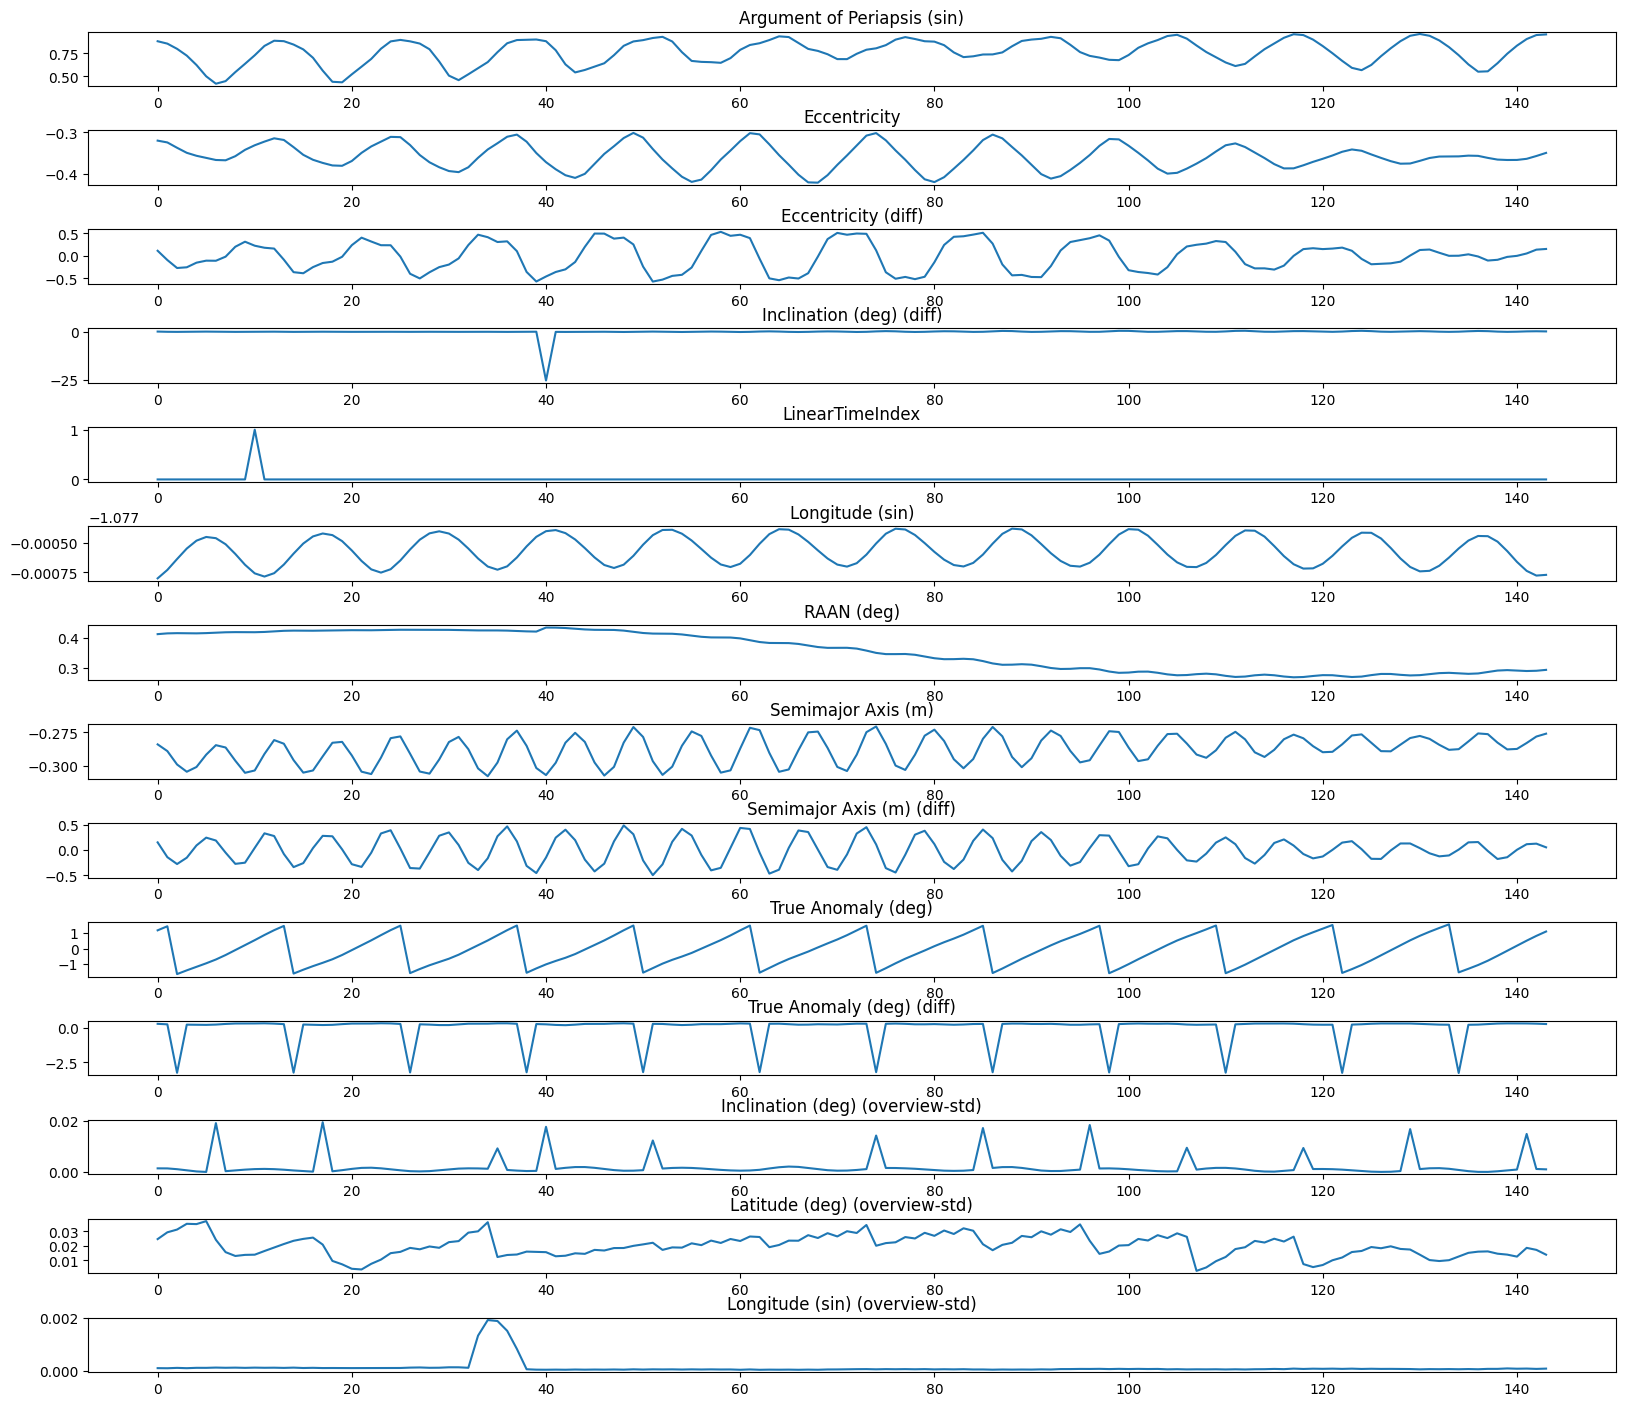

In [79]:
ds_gen.plot_dataset_items(val_combined, 212, 250)

In [19]:
dense_model = prediction_models.Dense_NN(val_combined,
                                         conv1d_layers=[[32,5,4,1,1]],
                                         dense_layers=[64,32],
                                         lstm_layers=[[32,16,2]],
                                         cnn_lstm_order='lstm_cnn',
                                         split_cnn=True,
                                         split_dense=False,
                                         split_lstm=True,
                                         l2_reg=0.001,
                                         input_dropout=0.01,
                                         mixed_dropout_dense=0.1,
                                         mixed_dropout_cnn=0.1,
                                         mixed_dropout_lstm=0.1,
                                         mixed_batchnorm_cnn=True, # if True, this fucks up inference big time! maybe re-visit?
                                         mixed_batchnorm_dense=True,
                                         mixed_batchnorm_lstm=True,
                                         mixed_batchnorm_before_relu=False,
                                         optimizer='RMSprop',
                                         lr_scheduler=[0.001, 500, 0.9],#, 250, 0.9],
                                         output_type='classification',
                                         seed=42)

#dense_model._model = create_timeseries_classification_model((65,6))

dense_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 local_in (InputLayer)       [(None, 176, 11)]            0         []                            
                                                                                                  
 global_in (InputLayer)      [(None, 176, 4)]             0         []                            
                                                                                                  
 dropout_6 (Dropout)         (None, 176, 11)              0         ['local_in[0][0]']            
                                                                                                  
 dropout_7 (Dropout)         (None, 176, 4)               0         ['global_in[0][0]']           
                                                                                            

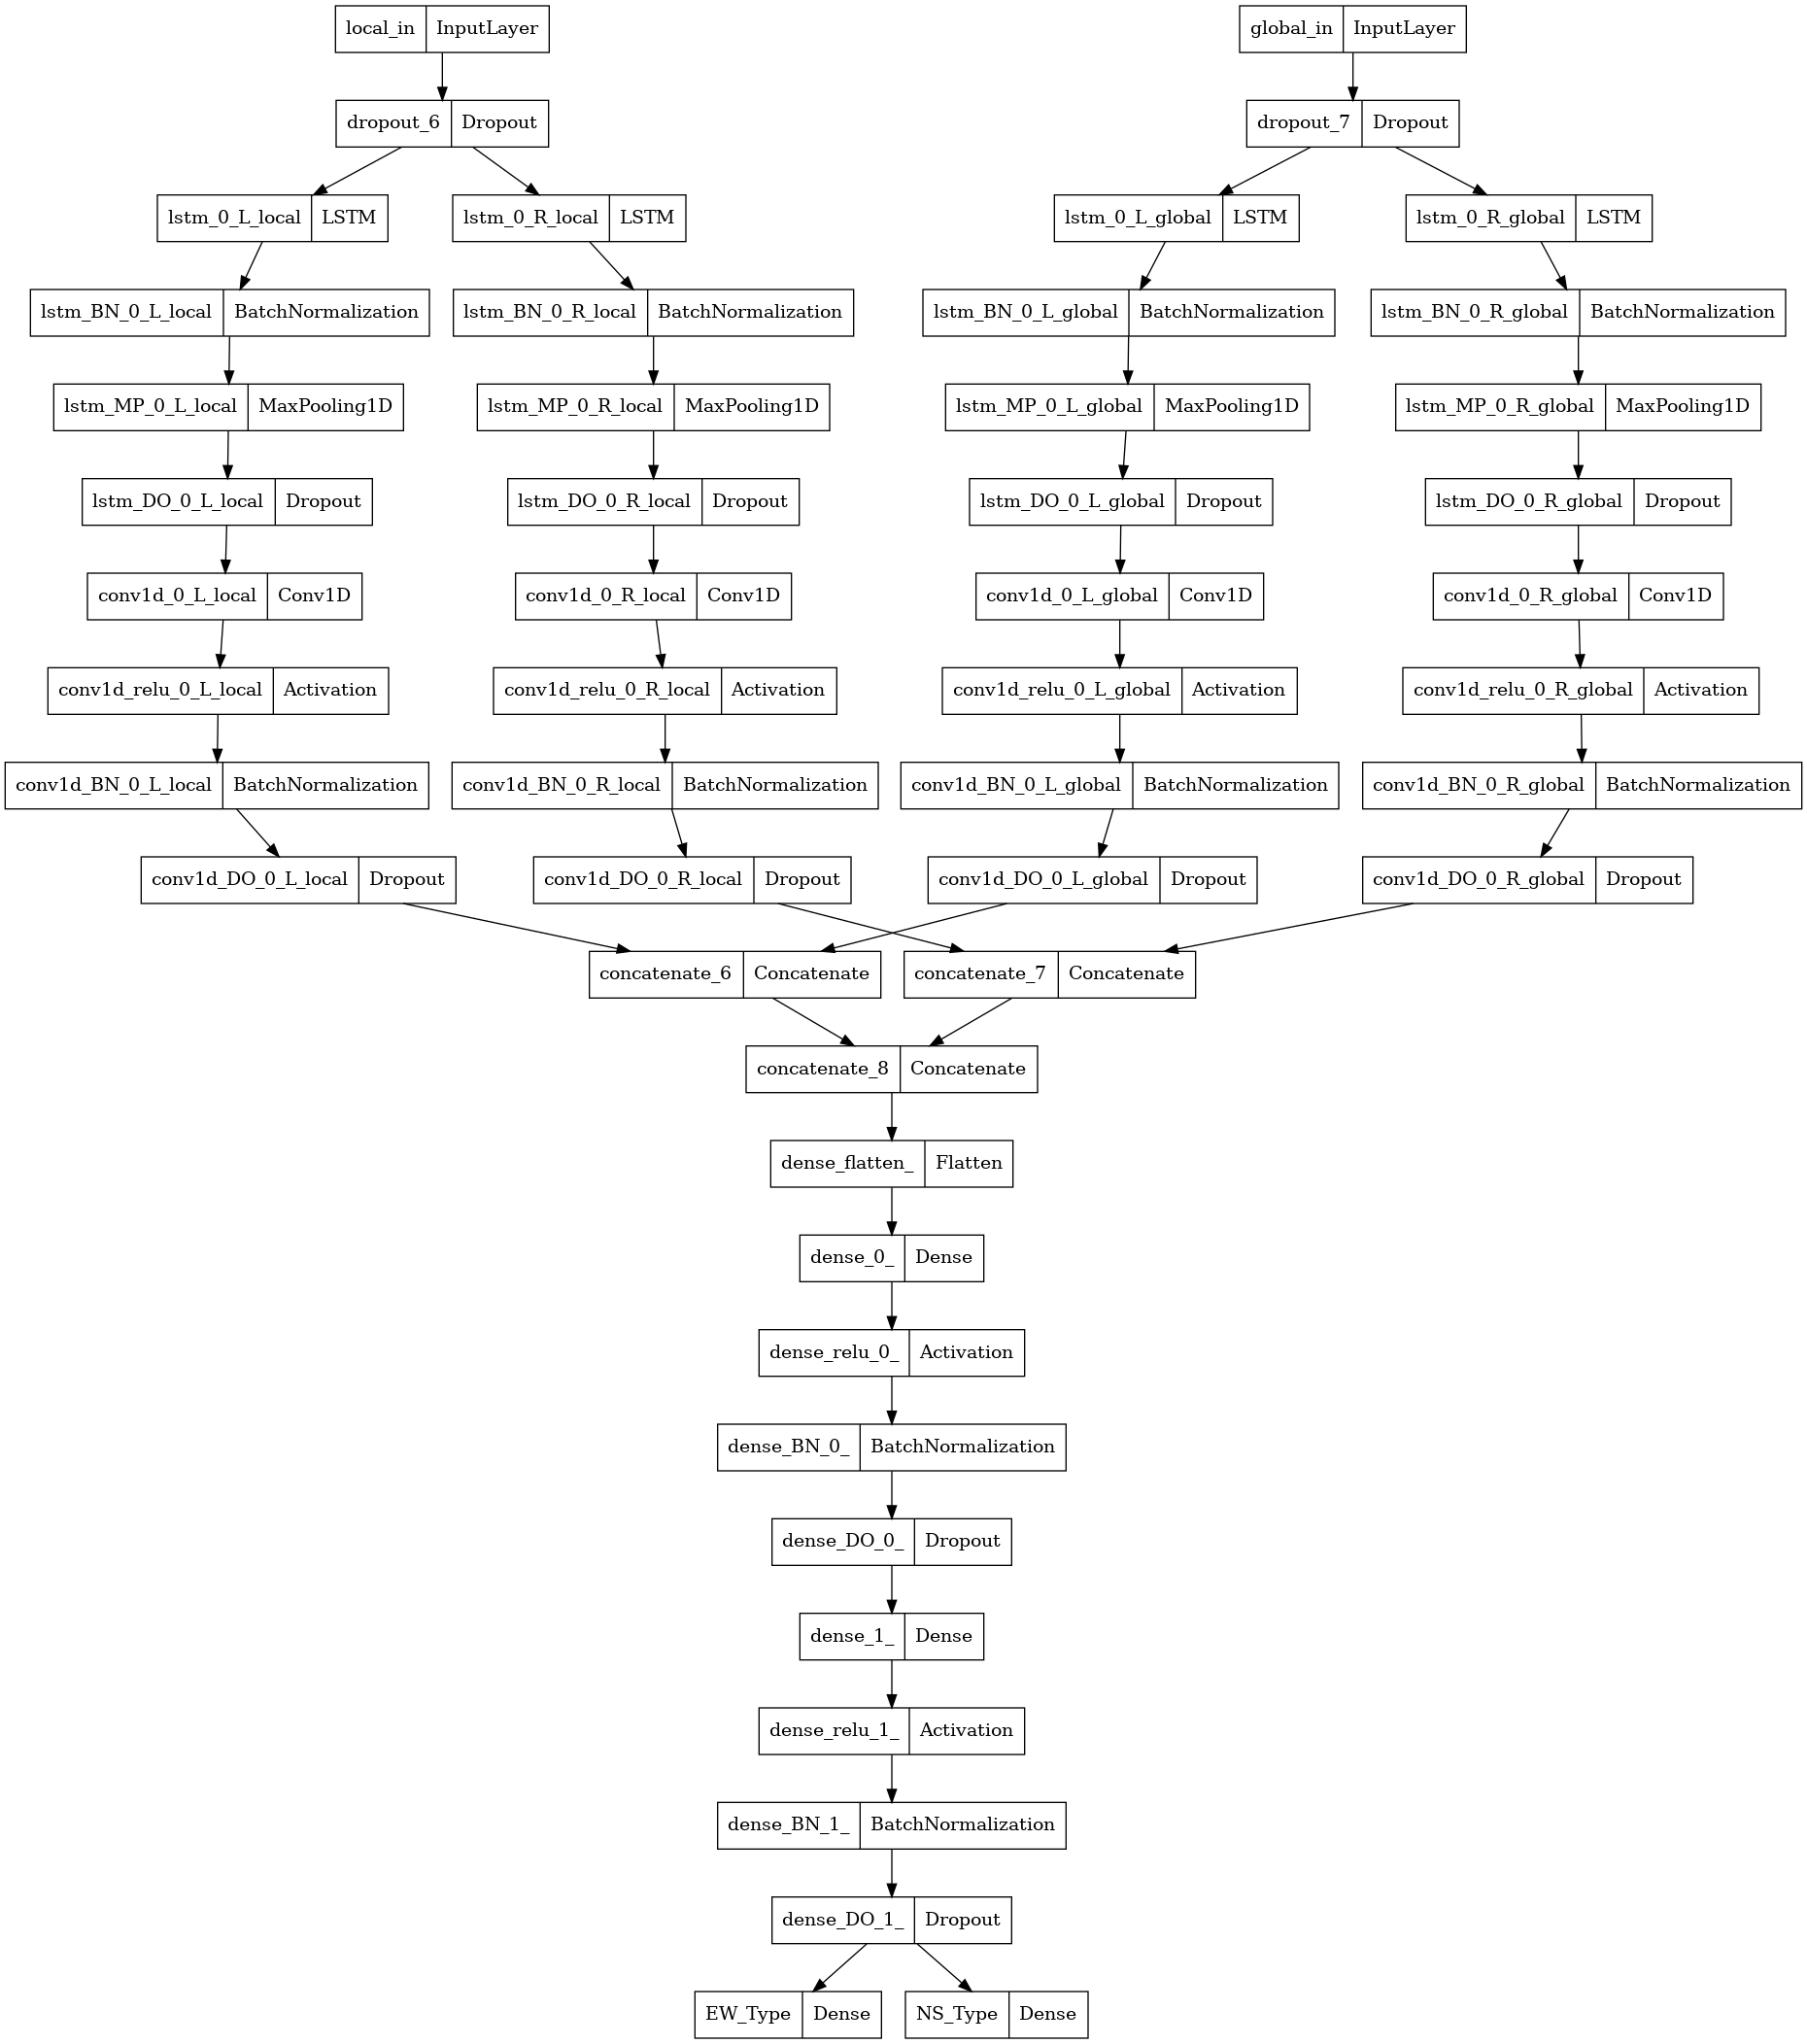

In [20]:
tf.keras.utils.plot_model(dense_model.model)

In [21]:
utils.set_random_seed(42)

dense_model.summary()

# temporary fix to allow class weights
# train_combined= train_combined.map(lambda x,y:(x,y[f'EW_Type']))
# val_combined = val_combined.map(lambda x,y:(x,y[f'EW_Type'])) 

# w_0 = 1.05
# w_1 = 1.2
# w_2 = 1.05
# w_3 = 0.65

hist = dense_model.fit(train_combined,
                       val_ds=val_combined,
                       epochs=500,
                       verbose=2,
                       plot_hist=True,
                       save_best_only=True,
                       early_stopping=70,
                       target_metric='val_EW_Type_accuracy',
                       #class_weight={0: w_0, 1: w_1, 2: w_2, 3: w_3},
                       callbacks=[])
dense_model.evaluate(val_combined)
#dense_model.model.save('models/ew_ns_classifier_new.hdf5')

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 local_in (InputLayer)       [(None, 176, 11)]            0         []                            
                                                                                                  
 global_in (InputLayer)      [(None, 176, 4)]             0         []                            
                                                                                                  
 dropout_6 (Dropout)         (None, 176, 11)              0         ['local_in[0][0]']            
                                                                                                  
 dropout_7 (Dropout)         (None, 176, 4)               0         ['global_in[0][0]']           
                                                                                            

KeyboardInterrupt: 

In [ ]:
hist = dense_model.fit(train_combined, val_ds=val_combined, early_stopping=40, target_metric='val_EW_Type_accuracy', epochs=100, verbose=2, plot_hist=True, callbacks=[])

In [4]:
dense_model = tf.keras.models.load_model("submission/models/model_wgosumdo.hdf5", compile=False )


2024-03-14 00:06:48.887450: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-14 00:06:48.915439: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-14 00:06:48.915579: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
#ds_gen.plot_dataset_items(val_combined)

2024-03-14 00:06:51.024492: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-14 00:06:51.091577: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-14 00:06:51.362517: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


3/3 [==============================] - 2s 254ms/step


/home/user/Code/splid-challenge/base/classifier.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


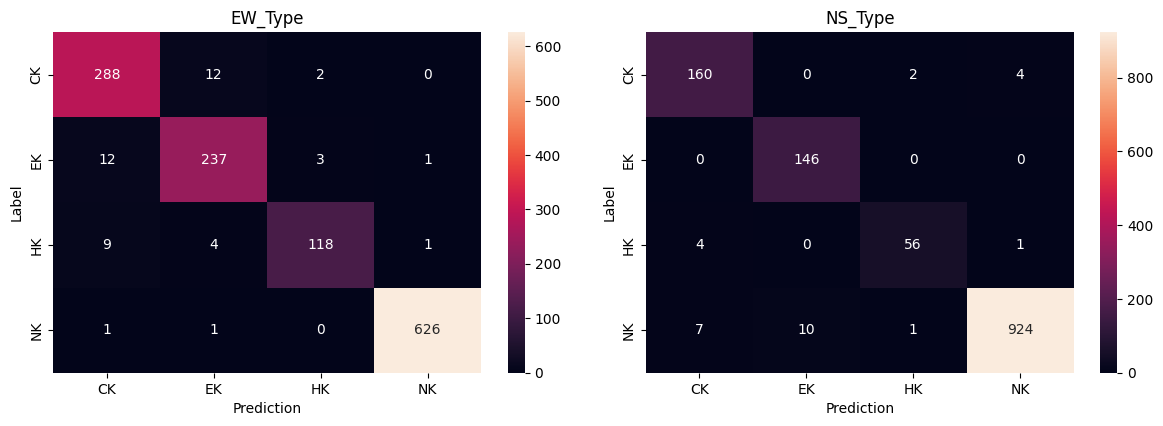

In [5]:
pred_df = classifier.create_prediction_df(ds_gen=ds_gen,
                                model=dense_model,
                                train=False,
                                test=False,
                                model_outputs=['EW_Type', 'NS_Type'],#, 'NS_Type'],
                                object_limit=None,
                                only_nodes=True,
                                confusion_matrix=True,
                                prediction_batches=1,
                                verbose=1)

In [9]:
ground_truth_df = pd.read_csv(challenge_data_dir / 'train_labels.csv')#.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
ground_truth_df=ground_truth_df.loc[(ground_truth_df['Node'] != 'ES')].copy()
ground_truth_df.loc[ground_truth_df['Node'] != 'ID', 'Type'] = 'UNKNOWN'
ground_truth_df.loc[ground_truth_df['Node'] != 'ID', 'Node'] = 'UNKNOWN'
#ground_truth_df.loc[ground_truth_df['Node'] == 'SS', 'Type'] = 'UNKNOWN'
#ground_truth_df.loc[ground_truth_df['Node'] == 'SS', 'Node'] = 'UNKNOWN'
#ground_truth_df['Type'] = 'UNKNOWN'
#ground_truth_df['Node'] = 'UNKNOWN'

typed_df = classifier.fill_unknown_types_based_on_preds(pred_df, ground_truth_df, dirs=['EW', 'NS'])
classified_df = classifier.fill_unknwon_nodes_based_on_type(typed_df, dirs=['EW', 'NS'])

# ground_truth_df=ground_truth_df.loc[ground_truth_df['TimeIndex']==0]
# majority_df=majority_df.loc[majority_df['TimeIndex']==0]
# ground_truth_df=ground_truth_df.loc[ground_truth_df['Direction']=='EW']
# majority_df=majority_df.loc[majority_df['Direction']=='EW']

# 0.95 with 3-layer cnn and 128@2 horizon

# 0.971 1768 53l
# 0.965
ground_truth_eval_df = pd.read_csv(challenge_data_dir / 'train_labels.csv')
evaluator = evaluation.NodeDetectionEvaluator(ground_truth=ground_truth_eval_df, participant=classified_df, ignore_nodes=True)
precision, recall, f2, rmse, total_tp, total_fp, total_fn, total_df = evaluator.score()
print(f'Precision: {precision:.3f}')
print(f'TP: {total_tp} FP: {total_fp}')

evaluator = evaluation.NodeDetectionEvaluator(ground_truth=ground_truth_eval_df, participant=classified_df, ignore_nodes=False)
precision, recall, f2, rmse, total_tp, total_fp, total_fn, total_df = evaluator.score()
print(f'Precision: {precision:.3f}')
print(f'TP: {total_tp} FP: {total_fp}')

Evaluator ignoring nodes (i.e. only evaluating type)
Precision: 0.985
TP: 1790 FP: 28
Precision: 0.985
TP: 1790 FP: 28


In [10]:
print(total_df.loc[total_df['classification'] == 'FP'])

      ObjectID  TimeIndex Direction Node Type classification distance matched
1            1          0        NS   SS   HK             FP        0     NaN
2            1          0        NS   SS   CK             FP        0    True
25          12          0        EW   SS   HK             FP        0     NaN
26          12          0        NS   SS   HK             FP        0     NaN
27          12          0        EW   SS   NK             FP        0    True
28          12          0        NS   SS   NK             FP        0    True
188         91          0        NS   SS   CK             FP        0     NaN
189         91          0        NS   SS   NK             FP        0    True
193         93          0        NS   SS   CK             FP        0     NaN
194         93          0        NS   SS   NK             FP        0    True
301        119        636        NS   IK   HK             FP        0     NaN
302        119        636        NS   IK   CK             FP    

In [40]:
pickle.dump(ds_gen.scaler, open('submission/models/ew_ns_classifier_scaler_oneshot_cnn.pkl', 'wb'))
dense_model.save('submission/models/ew_ns_classifier_oneshot_cnn.hdf5')


/home/user/miniconda3/envs/splid/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


: 

In [15]:
id_localizer_scaler = pickle.load(open("submission/models/ew_ns_classifier_scaler_oneshot_cnn.pkl", 'rb'))
print(id_localizer_scaler.mean_)
print(ds_gen.scaler.mean_)

[ 1.43525508e-01  1.47726378e-03  5.72572940e-07  6.37146064e-05
  1.66936476e-17 -4.31212935e-02  8.17596442e+01  4.21609791e+07
 -7.24200621e+00  1.80074071e+02  1.95692249e-02]
[ 1.43525508e-01  1.47726378e-03  5.72572940e-07  6.37146064e-05
  1.66936476e-17 -4.31212935e-02  8.17596442e+01  4.21609791e+07
 -7.24200621e+00  1.80074071e+02  1.95692249e-02]


In [17]:
print(total_df.loc[(total_df['classification']=='FP') & (total_df['matched']==True)].head(30))

      ObjectID  TimeIndex Direction Node Type classification distance matched
2            1          0        EW   SS   CK             FP        0    True
3            1          0        NS   SS   CK             FP        0    True
12           5          0        EW   SS   HK             FP        0    True
13           5          0        NS   SS   HK             FP        0    True
25          10          0        EW   SS   NK             FP        0    True
31          12          0        EW   SS   EK             FP        0    True
32          12          0        NS   SS   NK             FP        0    True
165         77          0        NS   SS   NK             FP        0    True
172         80          0        NS   SS   NK             FP        0    True
195         91          0        NS   SS   NK             FP        0    True
200         93          0        NS   SS   NK             FP        0    True
213         99          0        NS   SS   NK             FP    

In [29]:
ground_truth_df.loc[((ground_truth_df['ObjectID'] == 1143) & (ground_truth_df['TimeIndex'] == 1033)), 'Type'] = 'NK'
ground_truth_df.loc[((ground_truth_df['ObjectID'] == 1143) & (ground_truth_df['TimeIndex'] == 1033)), 'Node'] = 'ID'
print(pred_df.loc[pred_df['ObjectID'] == 111].head(20))
tmp = classifier.fill_unknown_types_based_on_preds(pred_df, ground_truth_df, dirs=['EW', 'NS'])
print(tmp.loc[tmp['ObjectID'] == 1143].head(20))
tmp = classifier.fill_unknwon_nodes_based_on_type(tmp, dirs=['EW', 'NS'])
print(tmp.loc[tmp['ObjectID'] == 1143].head(20))

    ObjectID  TimeIndex  EW_Type_Pred EW_Type  NS_Type_Pred NS_Type Type Node
21       111          0             3      NK             3      NK   na   na
22       111        124             3      NK             3      NK   na   na
23       111        411             3      NK             3      NK   NK   ID
24       111        418             3      NK             3      NK   na   na
25       111        479             2      HK             2      HK   na   na
      ObjectID  TimeIndex Direction     Node Type
1176      1143          0        EW  UNKNOWN   NK
1177      1143          0        NS  UNKNOWN   NK
1178      1143       1026        EW  UNKNOWN   NK
1179      1143       1033        EW       ID   NK
1180      1143       1082        NS  UNKNOWN   CK
1181      1143       1729        EW  UNKNOWN   NK
1182      1143       1729        NS  UNKNOWN   NK
      ObjectID  TimeIndex Direction Node Type
1176      1143          0        EW   SS   NK
1177      1143          0        NS   SS

In [16]:
print(total_df.loc[(total_df['classification']=='FP') & (total_df['matched']==True)].head(50))

      ObjectID  TimeIndex Direction Node Type classification distance matched
6            3          0        EW   SS   EK             FP        0    True
27          12          0        EW   SS   EK             FP        0    True
28          12          0        NS   SS   CK             FP        0    True
40          17          0        EW   SS   EK             FP        0    True
41          17          0        NS   SS   CK             FP        0    True
69          30          0        NS   SS   CK             FP        0    True
166         78          0        NS   SS   CK             FP        0    True
179         84          0        NS   SS   CK             FP        0    True
192         90          0        NS   SS   CK             FP        0    True
207         97          0        NS   SS   CK             FP        0    True
216        101          0        NS   SS   CK             FP        0    True
745        212        622        NS   IK   CK             FP    

In [45]:
test = range(10)
tmp_df = pd.DataFrame({'time':range(10), 'node' : 'blue'})
tmp_df2 = pd.DataFrame({'time':[5,7], 'node' : 'bla'})
tmp_df = pd.concat([tmp_df, tmp_df2]).reset_index(drop=True)

duplicate_indices = tmp_df.duplicated(subset=['time'], keep=False) # returns index of all duplicates
tmp_df.loc[duplicate_indices==True, 'node'] = 'UNKNOWN'
duplicate_indices_keep_first = tmp_df.duplicated(subset=['time'], keep='first') # returns index of all duplicates except the first
print(duplicate_indices_keep_first)
print(duplicate_indices_keep_first.sum())
print(len(duplicate_indices_keep_first))
tmp_df = tmp_df[duplicate_indices_keep_first==False]

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10     True
11     True
dtype: bool
2
12


In [20]:
print(dense_model.model.optimizer.learning_rate)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.005>


In [11]:
pickle.dump(ds_gen.scaler, open('submission/models/ew_ns_classifier_scaler_oneshot_cnn.pkl', 'wb'))
dense_model.model.save('submission/models/ew_ns_classifier_oneshot_cnn.hdf5')

#0.12 0.92 0.950 (no dropout, strong overfitting, no ft-transform)

/home/david/miniconda3/envs/splid-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
